In [12]:
import pandas as pd
import glob
import numpy as np
import os
import datetime as dt
import nltk
import string
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import Word
from nltk.stem import PorterStemmer

In [13]:
studies = pd.read_csv("data_by_tables/Studies.csv",index_col=0)
studies.shape

C:\Users\aishg\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (5,13,14,15,37,42,47,48,49,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(284918, 64)

In [14]:
stop_list = stopwords.words('english')
stop_list.extend(("a", "an","the","with","ii","iii","iv","non",
                  "studies","use","study","multiple", "single", "double",
                  "this","these","those","care","effect","health","patients",
                  "trial","treatment","versus","clinical","clinic","controlled","control"))


In [15]:
def nlp_pipeline(series):
    series = series.apply(lambda x: [elem.strip() for elem in x])
    series = series.apply(lambda x: [elem for elem in x if not elem.isdigit()])
    series = series.apply(lambda x: [elem.lower() for elem in x])
    series = series.apply(lambda x: [elem for elem in x if elem not in stop_list])
    series = series.apply(lambda x: [elem.replace('[^\w\s]','') for elem in x])
    
    st = PorterStemmer()
    series = series.apply(lambda x: [st.stem(elem) for elem in x])
    series = series.apply(lambda x: [Word(elem).lemmatize() for elem in x])
    series = series.apply(lambda x: ' '.join(x))
    return series

In [16]:
def topic_model(source_df, 
                col_name, 
                desc_col_type):
    
       
    chosen_df = source_df.copy()
    chosen_df = chosen_df[chosen_df.is_fda_regulated_drug == True]
    chosen_df = chosen_df[~chosen_df[col_name].isnull()]
    chosen_df = chosen_df.groupby('nct_id').apply(lambda x: x[col_name].tolist())
    
    
    if desc_col_type == 'one':
        chosen_df = chosen_df.apply(lambda x:x[0]).apply(lambda x: x.strip()).apply(lambda x: x.split(' '))
    
    chosen_df = nlp_pipeline(chosen_df)

    
     
    return chosen_df

In [17]:
text_data = topic_model(studies, "official_title","one")

from gensim import corpora
s = pd.Series(text_data)
final_data = s.str.split()
dictionary = corpora.Dictionary(final_data)
corpus = [dictionary.doc2bow(text) for text in final_data]

import gensim

topic_size = [10,12,14,16,18,20,22,24,26,28,30]
topic_log_perplexity = []
topic_params = []

for NUM_TOPICS in topic_size:
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#     topics = lda_model.print_topics(num_words=4)
#     for topic in topics:
#         print(topic)
        
    # Log Likelyhood: Higher the better
    print("Log Likelihood: ", lda_model.log_perplexity(corpus))
    topic_log_perplexity.append(lda_model.log_perplexity(corpus))
    
    # See model parameters
#     print(lda_model.get_topics())
#     topic_params.append(lda_model.get_topics())

C:\Users\aishg\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Log Likelihood:  -7.8954713559866345
Log Likelihood:  -7.900779464047438
Log Likelihood:  -7.8992375923916285
Log Likelihood:  -7.928483280365896
Log Likelihood:  -7.961442092600979
Log Likelihood:  -7.9396873903459015
Log Likelihood:  -7.961820380744126
Log Likelihood:  -7.943557029984457
Log Likelihood:  -7.991796891609381
Log Likelihood:  -8.003873109490193
Log Likelihood:  -7.9951712686313705


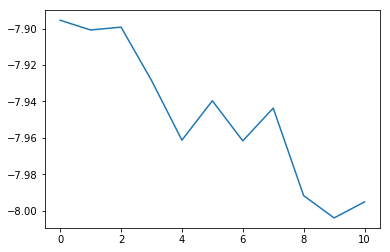

In [18]:
plt.plot(topic_log_perplexity)

In [19]:
topics = lda_model.print_topics(num_topics=40, num_words=4)
for topic in topics:
    print(topic)

(0, '0.038*"acut" + 0.034*"syndrom" + 0.032*"chronic" + 0.025*"inhal"')
(1, '0.082*"vaccin" + 0.051*"age" + 0.050*"year" + 0.041*"immunogen"')
(2, '0.024*"open-label" + 0.023*"infect" + 0.018*"phase" + 0.016*"subject"')
(3, '0.044*"human" + 0.020*"monoclon" + 0.015*"respiratori" + 0.014*"antibodi"')
(4, '0.060*"safety," + 0.053*"subject" + 0.048*"pharmacokinet" + 0.044*"phase"')
(5, '0.034*"psoriasi" + 0.031*"factor" + 0.031*"1b" + 0.029*"plaqu"')
(6, '0.024*"manag" + 0.023*"pain" + 0.021*"solut" + 0.019*"reduc"')
(7, '0.082*"phase" + 0.069*"tumor" + 0.051*"advanc" + 0.049*"solid"')
(8, '0.057*"phase" + 0.049*"cancer" + 0.042*"combin" + 0.027*"metastat"')
(9, '0.050*"prostat" + 0.038*"cancer" + 0.035*"therapi" + 0.020*"random"')
(10, '0.031*"diabet" + 0.031*"imag" + 0.025*"type" + 0.024*"function"')
(11, '0.058*"cancer" + 0.056*"breast" + 0.045*"phase" + 0.025*"combin"')
(12, '0.052*"refractori" + 0.044*"relaps" + 0.037*"phase" + 0.032*"myeloma"')
(13, '0.048*"healthi" + 0.031*"crossov

## Topic Modeling Visualization

In [20]:
from gensim.corpora import Dictionary

# Create a dictionary(vocab) with all tokens
dictionary = Dictionary(final_data)

# Filter tokens which appear less than 5 times,
# and those which appear more than 50% of the time.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert our documents to bag-of-words
corpus = [dictionary.doc2bow(text) for text in final_data]

In [21]:
dictionary_file_path = 'Goldman.dict'
dictionary.save(dictionary_file_path)

In [23]:
from gensim.models import LdaModel
# Set random seed to reproduce results
np.random.seed(42)

NUM_TOPICS = 30

# Caution: the below parameters will take a long time to run
# First run it with default parameters
passes = 20
iterations = 400
eval_every = 50

# Increase the number of passes to get better results. But it'll takes more time
ldamodel = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, 
                    passes=passes,
                   iterations=iterations,
                   eval_every=eval_every)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.03333333333333333
INFO:gensim.models.ldamodel:using symmetric eta at 0.03333333333333333
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (multi-pass) LDA training, 30 topics, 20 passes over the supplied corpus of 13625 documents, updating model once every 2000 documents, evaluating perplexity every 13625 documents, iterating 400x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #17 (0.033): 0.049*"phase" + 0.016*"subject" + 0.015*"evalu" + 0.013*"efficaci" + 0.012*"chronic" + 0.010*

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #9 (0.033): 0.054*"phase" + 0.035*"nivolumab" + 0.030*"randomized," + 0.027*"acut" + 0.023*"efficaci" + 0.022*"safeti" + 0.021*"subject" + 0.021*"leukemia" + 0.021*"double-blind," + 0.021*"combin"
INFO:gensim.models.ldamodel:topic #13 (0.033): 0.071*"randomized," + 0.062*"double-blind," + 0.057*"safeti" + 0.052*"efficaci" + 0.036*"evalu" + 0.029*"subject" + 0.028*"multicenter," + 0.027*"placebo-control" + 0.026*"placebo-controlled," + 0.023*"phase"
INFO:gensim.models.ldamodel:topic #29 (0.033): 0.024*"test" + 0.023*"phase" + 0.023*"pain" + 0.018*"cancer" + 0.018*"deliveri" + 0.016*"reduct" + 0.014*"util" + 0.014*"patient" + 0.012*"pilot" + 0.012*"venou"
INF

INFO:gensim.models.ldamodel:topic #1 (0.033): 0.030*"biomark" + 0.028*"respons" + 0.026*"outcom" + 0.026*"observ" + 0.025*"diseas" + 0.023*"alzheimer'" + 0.018*"individu" + 0.017*"effect" + 0.015*"therapi" + 0.015*"genotyp"
INFO:gensim.models.ldamodel:topic #5 (0.033): 0.045*"safeti" + 0.036*"efficaci" + 0.029*"randomised," + 0.029*"pulmonari" + 0.024*"hypertens" + 0.021*"evalu" + 0.020*"atop" + 0.019*"dermat" + 0.018*"phase" + 0.018*"bladder"
INFO:gensim.models.ldamodel:topic #12 (0.033): 0.042*"safeti" + 0.041*"efficaci" + 0.028*"infect" + 0.028*"evalu" + 0.027*"diseas" + 0.027*"chronic" + 0.022*"randomized," + 0.022*"phase" + 0.022*"subject" + 0.020*"activ"
INFO:gensim.models.ldamodel:topic #24 (0.033): 0.028*"immunogen" + 0.028*"vaccin" + 0.026*"viru" + 0.024*"dose" + 0.024*"adult" + 0.023*"c" + 0.021*"open" + 0.020*"hepat" + 0.018*"label," + 0.017*"evalu"
INFO:gensim.models.ldamodel:topic #20 (0.033): 0.057*"safety," + 0.053*"pharmacokinet" + 0.051*"randomized," + 0.050*"healthi" 

INFO:gensim.models.ldamodel:topic #25 (0.033): 0.144*"cancer" + 0.083*"phase" + 0.072*"metastat" + 0.055*"breast" + 0.035*"advanc" + 0.033*"prostat" + 0.032*"combin" + 0.028*"local" + 0.024*"plu" + 0.021*"therapi"
INFO:gensim.models.ldamodel:topic #11 (0.033): 0.069*"type" + 0.067*"diabet" + 0.057*"function" + 0.040*"renal" + 0.025*"failur" + 0.025*"heart" + 0.024*"insulin" + 0.023*"impair" + 0.021*"metformin" + 0.020*"improv"
INFO:gensim.models.ldamodel:topic #2 (0.033): 0.063*"effect" + 0.048*"random" + 0.028*"disord" + 0.027*"symptom" + 0.021*"alcohol" + 0.019*"pilot" + 0.018*"opioid" + 0.017*"metabol" + 0.016*"gel" + 0.014*"depend"
INFO:gensim.models.ldamodel:topic diff=0.205117, rho=0.319235
INFO:gensim.models.ldamodel:PROGRESS: pass 2, at document #6000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.

INFO:gensim.models.ldamodel:topic #19 (0.033): 0.045*"immun" + 0.042*"syndrom" + 0.039*"risk" + 0.037*"system" + 0.033*"high" + 0.032*"formul" + 0.031*"earli" + 0.025*"therapi" + 0.023*"novel" + 0.019*"myelodysplast"
INFO:gensim.models.ldamodel:topic diff=0.118925, rho=0.319235
INFO:gensim.models.ldamodel:PROGRESS: pass 3, at document #2000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #26 (0.033): 0.137*"cell" + 0.091*"transplant" + 0.056*"stem" + 0.034*"allogen" + 0.029*"carcinoma" + 0.028*"hematopoiet" + 0.028*"phase" + 0.025*"autolog" + 0.025*"squamou" + 0.024*"head"
INFO:gensim.models.ldamodel:topic #25 (0.033): 0.152*"cancer" + 0.086*"phase" + 0.071*"metastat" + 0.057*"breast" + 0.038*"adva

INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #11 (0.033): 0.074*"diabet" + 0.071*"type" + 0.054*"function" + 0.039*"renal" + 0.035*"heart" + 0.032*"failur" + 0.029*"insulin" + 0.027*"impair" + 0.024*"improv" + 0.021*"metformin"
INFO:gensim.models.ldamodel:topic #24 (0.033): 0.048*"vaccin" + 0.046*"immunogen" + 0.039*"age" + 0.038*"year" + 0.026*"adult" + 0.024*"viru" + 0.024*"safeti" + 0.023*"open" + 0.022*"label," + 0.020*"evalu"
INFO:gensim.models.ldamodel:topic #10 (0.033): 0.081*"phase" + 0.043*"primari" + 0.037*"recurr" + 0.024*"influenza" + 0.023*"combin" + 0.021*"vaccin" + 0.018*"venetoclax" + 0.016*"glioma" + 0.016*"grade" + 0.016*"progress"
INFO:gensim.models.ldamodel:topic #1 (0.033): 0.036*"outcom" + 0.035*"respons" + 0.034*"diseas" + 0.031*"biomark" + 0.029*"observ" + 0.029*"alzheimer'" + 0.025*"level" + 0.024*"effect" + 0.023*"liver" + 0.021*"hiv"
INFO:gensim.models.ldamodel:topic #15 (0.0

INFO:gensim.models.ldamodel:topic #4 (0.033): 0.072*"child" + 0.041*"adolesc" + 0.039*"blood" + 0.039*"infus" + 0.028*"young" + 0.025*"adult" + 0.021*"feasibl" + 0.020*"ketamin" + 0.019*"pilot" + 0.019*"cord"
INFO:gensim.models.ldamodel:topic #6 (0.033): 0.054*"lymphoma" + 0.048*"diagnos" + 0.047*"newli" + 0.043*"manag" + 0.030*"b-cell" + 0.029*"tissu" + 0.025*"sarcoma" + 0.025*"diffus" + 0.024*"larg" + 0.021*"medic"
INFO:gensim.models.ldamodel:topic #18 (0.033): 0.037*"lymphocyt" + 0.032*"chronic" + 0.026*"postop" + 0.023*"fibrosi" + 0.021*"biolog" + 0.020*"optim" + 0.019*"continu" + 0.019*"parkinson'" + 0.019*"cystic" + 0.018*"therapi"
INFO:gensim.models.ldamodel:topic diff=0.059087, rho=0.290957
INFO:gensim.models.ldamodel:PROGRESS: pass 4, at document #10000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.mode

INFO:gensim.models.ldamodel:topic #23 (0.033): 0.081*"pembrolizumab" + 0.057*"phase" + 0.037*"+" + 0.031*"unresect" + 0.028*"kina" + 0.026*"metastat" + 0.025*"first-lin" + 0.022*"combin" + 0.021*"(mk-3475)" + 0.019*"carcinoma"
INFO:gensim.models.ldamodel:topic diff=0.061749, rho=0.279372
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #6000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #10 (0.033): 0.086*"phase" + 0.052*"primari" + 0.044*"recurr" + 0.023*"progress" + 0.022*"combin" + 0.020*"glioma" + 0.019*"influenza" + 0.018*"grade" + 0.015*"ib/ii" + 0.015*"venetoclax"
INFO:gensim.models.ldamodel:topic #6 (0.033): 0.059*"lymphoma" + 0.052*"diagnos" + 0.048*"newli" + 0.034*"manag" + 0.0

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #25 (0.033): 0.155*"cancer" + 0.088*"phase" + 0.072*"metastat" + 0.061*"breast" + 0.040*"advanc" + 0.036*"prostat" + 0.034*"combin" + 0.031*"local" + 0.022*"plu" + 0.021*"therapi"
INFO:gensim.models.ldamodel:topic #2 (0.033): 0.081*"effect" + 0.070*"random" + 0.032*"symptom" + 0.022*"woman" + 0.022*"prospect" + 0.020*"metabol" + 0.020*"gel" + 0.020*"disord" + 0.019*"opioid" + 0.019*"alcohol"
INFO:gensim.models.ldamodel:topic #12 (0.033): 0.035*"activ" + 0.032*"infect" + 0.029*"chronic" + 0.028*"safeti" + 0.024*"diseas" + 0.022*"b" + 0.020*"efficaci" + 0.018*"evalu" + 0.017*"phase" + 0.016*"hepat"
INFO:gensim.models.ldamodel:topic #7 (0.033): 0.098*"phase" +

INFO:gensim.models.ldamodel:topic #15 (0.033): 0.088*"inject" + 0.064*"human" + 0.030*"knee" + 0.028*"macular" + 0.027*"gene" + 0.027*"use" + 0.025*"potenti" + 0.025*"surgic" + 0.018*"drug" + 0.018*"imag"
INFO:gensim.models.ldamodel:topic #6 (0.033): 0.051*"lymphoma" + 0.045*"diagnos" + 0.043*"newli" + 0.041*"manag" + 0.029*"b-cell" + 0.027*"diffus" + 0.026*"tissu" + 0.025*"larg" + 0.025*"sarcoma" + 0.021*"medic"
INFO:gensim.models.ldamodel:topic #9 (0.033): 0.112*"acut" + 0.069*"leukemia" + 0.066*"phase" + 0.042*"myeloid" + 0.029*"combin" + 0.019*"first" + 0.019*"line" + 0.017*"lymphoblast" + 0.017*"hepatocellular" + 0.015*"chemotherapi"
INFO:gensim.models.ldamodel:topic diff=0.038346, rho=0.269069
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-6.936 per-word bound, 122.5 perplexity estimate based on a held-out corpus of 1625 documents with 18501 words
INFO:gensim.models.ldamodel:PROGRESS: pass 6, at document #13625/13625
DEBUG:gensim.models.ldamodel:p

INFO:gensim.models.ldamodel:topic #6 (0.033): 0.054*"lymphoma" + 0.049*"diagnos" + 0.048*"newli" + 0.043*"manag" + 0.029*"tissu" + 0.028*"b-cell" + 0.026*"sarcoma" + 0.026*"diffus" + 0.024*"larg" + 0.023*"rituximab"
INFO:gensim.models.ldamodel:topic diff=0.038777, rho=0.259828
INFO:gensim.models.ldamodel:PROGRESS: pass 7, at document #10000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #2 (0.033): 0.084*"effect" + 0.073*"random" + 0.025*"symptom" + 0.025*"prospect" + 0.022*"placebo" + 0.021*"metabol" + 0.020*"double-blind" + 0.019*"woman" + 0.019*"disord" + 0.018*"gel"
INFO:gensim.models.ldamodel:topic #25 (0.033): 0.149*"cancer" + 0.086*"phase" + 0.069*"metastat" + 0.060*"breast" + 0.040*"advanc

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #6 (0.033): 0.060*"lymphoma" + 0.052*"diagnos" + 0.049*"newli" + 0.035*"manag" + 0.030*"b-cell" + 0.028*"rituximab" + 0.028*"diffus" + 0.027*"tissu" + 0.026*"larg" + 0.024*"sarcoma"
INFO:gensim.models.ldamodel:topic #29 (0.033): 0.041*"pain" + 0.033*"induc" + 0.033*"impact" + 0.028*"skin" + 0.027*"test" + 0.025*"patient" + 0.025*"deliveri" + 0.022*"egfr" + 0.018*"study:" + 0.018*"venou"
INFO:gensim.models.ldamodel:topic #2 (0.033): 0.085*"effect" + 0.080*"random" + 0.025*"symptom" + 0.024*"prospect" + 0.022*"metabol" + 0.021*"placebo" + 0.021*"alcohol" + 0.020*"double-blind" + 0.019*"blind" + 0.019*"pilot"
INFO:gensim.models.ldamodel:topic #4 (0.033): 0.074

INFO:gensim.models.ldamodel:topic #19 (0.033): 0.057*"syndrom" + 0.056*"risk" + 0.051*"high" + 0.036*"immun" + 0.035*"system" + 0.034*"dose" + 0.029*"low" + 0.028*"myelodysplast" + 0.026*"therapi" + 0.025*"novel"
INFO:gensim.models.ldamodel:topic #20 (0.033): 0.073*"safety," + 0.068*"pharmacokinet" + 0.059*"subject" + 0.056*"healthi" + 0.047*"phase" + 0.046*"dose" + 0.041*"evalu" + 0.040*"randomized," + 0.036*"tolerability," + 0.027*"1,"
INFO:gensim.models.ldamodel:topic #13 (0.033): 0.115*"randomized," + 0.086*"efficaci" + 0.084*"double-blind," + 0.080*"safeti" + 0.047*"evalu" + 0.046*"phase" + 0.037*"placebo-control" + 0.037*"subject" + 0.034*"placebo-controlled," + 0.032*"multicenter,"
INFO:gensim.models.ldamodel:topic #7 (0.033): 0.100*"phase" + 0.084*"refractori" + 0.075*"relaps" + 0.047*"lymphoma" + 0.037*"cell" + 0.032*"i/ii" + 0.030*"receptor" + 0.023*"express" + 0.021*"radiotherapi" + 0.019*"glioblastoma"
INFO:gensim.models.ldamodel:topic diff=0.068614, rho=0.243884
INFO:gensi

INFO:gensim.models.ldamodel:topic #24 (0.033): 0.065*"vaccin" + 0.051*"year" + 0.050*"age" + 0.050*"immunogen" + 0.031*"adult" + 0.030*"safeti" + 0.029*"label," + 0.028*"open" + 0.022*"evalu" + 0.018*"administ"
INFO:gensim.models.ldamodel:topic #6 (0.033): 0.051*"lymphoma" + 0.046*"diagnos" + 0.044*"newli" + 0.041*"manag" + 0.030*"b-cell" + 0.027*"diffus" + 0.026*"tissu" + 0.025*"sarcoma" + 0.025*"larg" + 0.021*"medic"
INFO:gensim.models.ldamodel:topic diff=0.030865, rho=0.243884
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-6.935 per-word bound, 122.3 perplexity estimate based on a held-out corpus of 1625 documents with 18501 words
INFO:gensim.models.ldamodel:PROGRESS: pass 9, at document #13625/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1625 documents
DEBUG:gensim.models.ldamodel:1625/1625 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 

INFO:gensim.models.ldamodel:topic diff=0.031738, rho=0.236940
INFO:gensim.models.ldamodel:PROGRESS: pass 10, at document #10000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #29 (0.033): 0.044*"pain" + 0.034*"impact" + 0.031*"skin" + 0.029*"induc" + 0.029*"test" + 0.028*"patient" + 0.021*"deliveri" + 0.021*"study:" + 0.017*"egfr" + 0.017*"reduct"
INFO:gensim.models.ldamodel:topic #2 (0.033): 0.082*"effect" + 0.081*"random" + 0.025*"symptom" + 0.024*"prospect" + 0.023*"placebo" + 0.021*"double-blind" + 0.021*"metabol" + 0.021*"woman" + 0.019*"compar" + 0.018*"gel"
INFO:gensim.models.ldamodel:topic #26 (0.033): 0.154*"cell" + 0.085*"transplant" + 0.052*"stem" + 0.033*"phase" + 0.032*"carcinoma" + 0

INFO:gensim.models.ldamodel:topic #29 (0.033): 0.044*"pain" + 0.033*"impact" + 0.033*"induc" + 0.028*"skin" + 0.027*"test" + 0.026*"patient" + 0.025*"deliveri" + 0.022*"egfr" + 0.018*"study:" + 0.017*"venou"
INFO:gensim.models.ldamodel:topic #28 (0.033): 0.088*"safeti" + 0.075*"efficaci" + 0.067*"evalu" + 0.048*"phase" + 0.046*"open-label," + 0.041*"subject" + 0.040*"open-label" + 0.029*"multicenter," + 0.025*"chronic" + 0.024*"multicent"
INFO:gensim.models.ldamodel:topic #20 (0.033): 0.077*"safety," + 0.071*"pharmacokinet" + 0.058*"subject" + 0.052*"healthi" + 0.047*"dose" + 0.047*"phase" + 0.041*"evalu" + 0.039*"randomized," + 0.038*"tolerability," + 0.025*"1,"
INFO:gensim.models.ldamodel:topic #6 (0.033): 0.059*"lymphoma" + 0.052*"diagnos" + 0.048*"newli" + 0.035*"manag" + 0.030*"b-cell" + 0.028*"rituximab" + 0.028*"diffus" + 0.027*"tissu" + 0.026*"larg" + 0.024*"sarcoma"
INFO:gensim.models.ldamodel:topic #24 (0.033): 0.072*"vaccin" + 0.052*"year" + 0.049*"age" + 0.047*"immunogen" +

INFO:gensim.models.ldamodel:topic #16 (0.033): 0.084*"open" + 0.075*"label" + 0.044*"acid" + 0.039*"reduc" + 0.030*"inhal" + 0.026*"relat" + 0.025*"protocol" + 0.025*"asthma" + 0.021*"role" + 0.021*"condit"
INFO:gensim.models.ldamodel:topic #29 (0.033): 0.046*"pain" + 0.033*"induc" + 0.031*"impact" + 0.028*"test" + 0.027*"patient" + 0.026*"skin" + 0.024*"deliveri" + 0.020*"egfr" + 0.019*"study:" + 0.015*"inflammatori"
INFO:gensim.models.ldamodel:topic #7 (0.033): 0.101*"phase" + 0.090*"refractori" + 0.082*"relaps" + 0.046*"lymphoma" + 0.036*"cell" + 0.033*"i/ii" + 0.030*"receptor" + 0.023*"express" + 0.021*"radiotherapi" + 0.019*"glioblastoma"
INFO:gensim.models.ldamodel:topic diff=0.061158, rho=0.224662
INFO:gensim.models.ldamodel:PROGRESS: pass 12, at document #4000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensi

INFO:gensim.models.ldamodel:topic diff=0.026956, rho=0.224662
DEBUG:gensim.models.ldamodel:bound: at document #0
INFO:gensim.models.ldamodel:-6.933 per-word bound, 122.2 perplexity estimate based on a held-out corpus of 1625 documents with 18501 words
INFO:gensim.models.ldamodel:PROGRESS: pass 12, at document #13625/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1625 documents
DEBUG:gensim.models.ldamodel:1625/1625 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1625 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #20 (0.033): 0.072*"safety," + 0.068*"pharmacokinet" + 0.060*"healthi" + 0.060*"subject" + 0.047*"phase" + 0.045*"dose" + 0.042*"evalu" + 0.039*"randomized," + 0.037*"tolerability," + 0.029*"1,"
INFO:gensim.models.ldamodel:topic #0 (0.033): 0.084*"phase" + 0.060*"tumor" + 0.049*"advanc" + 0.046*"solid" + 0.041*"dose" + 0.038*"open-label," 

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #15 (0.033): 0.086*"inject" + 0.062*"human" + 0.034*"gene" + 0.030*"knee" + 0.027*"macular" + 0.027*"use" + 0.026*"surgic" + 0.021*"potenti" + 0.020*"drug" + 0.017*"imag"
INFO:gensim.models.ldamodel:topic #20 (0.033): 0.073*"safety," + 0.069*"pharmacokinet" + 0.061*"subject" + 0.057*"healthi" + 0.047*"phase" + 0.046*"dose" + 0.041*"evalu" + 0.039*"randomized," + 0.038*"tolerability," + 0.028*"1,"
INFO:gensim.models.ldamodel:topic #16 (0.033): 0.088*"open" + 0.079*"label" + 0.043*"acid" + 0.037*"reduc" + 0.028*"asthma" + 0.026*"inhal" + 0.025*"ibrutinib" + 0.024*"relat" + 0.021*"condit" + 0.021*"role"
INFO:gensim.models.ldamodel:topic #23 (0.033): 0.102*"pembrolizumab" + 0.062*"phase" + 0.040*"unresect" + 0.036*"metastat" + 0.031*"+" + 0.029*"combin" + 0.028*"first-lin" + 0.022*"carcinoma" + 0.021*"kina" + 0.019*"m

INFO:gensim.models.ldamodel:topic #22 (0.033): 0.069*"surgeri" + 0.053*"imag" + 0.047*"brain" + 0.040*"undergo" + 0.025*"cardiac" + 0.023*"metastas" + 0.022*"injuri" + 0.021*"coronari" + 0.021*"exposur" + 0.020*"evalu"
INFO:gensim.models.ldamodel:topic #3 (0.033): 0.070*"therapi" + 0.039*"mainten" + 0.036*"particip" + 0.035*"depress" + 0.034*"immunotherapi" + 0.028*"adjunct" + 0.027*"disord" + 0.025*"induct" + 0.024*"major" + 0.021*"bodi"
INFO:gensim.models.ldamodel:topic #17 (0.033): 0.108*"sever" + 0.086*"moder" + 0.037*"topic" + 0.036*"1b" + 0.035*"antibodi" + 0.028*"monoclon" + 0.026*"phase" + 0.024*"mild" + 0.022*"infant" + 0.021*"cognit"
INFO:gensim.models.ldamodel:topic diff=0.018869, rho=0.214115
INFO:gensim.models.ldamodel:PROGRESS: pass 14, at document #8000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensi

INFO:gensim.models.ldamodel:topic #27 (0.033): 0.081*"phase" + 0.050*"2," + 0.040*"3," + 0.034*"myeloma" + 0.032*"dexamethason" + 0.028*"subject" + 0.027*"randomized," + 0.026*"lenalidomid" + 0.025*"mellitu" + 0.019*"urotheli"
INFO:gensim.models.ldamodel:topic diff=0.055991, rho=0.209370
INFO:gensim.models.ldamodel:PROGRESS: pass 15, at document #4000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #20 (0.033): 0.076*"safety," + 0.073*"pharmacokinet" + 0.060*"subject" + 0.056*"healthi" + 0.047*"dose" + 0.046*"phase" + 0.041*"evalu" + 0.037*"tolerability," + 0.037*"randomized," + 0.026*"1,"
INFO:gensim.models.ldamodel:topic #11 (0.033): 0.076*"type" + 0.074*"diabet" + 0.063*"function" + 0.049*"renal

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 1625 documents
DEBUG:gensim.models.ldamodel:1625/1625 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1625 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #29 (0.033): 0.055*"pain" + 0.034*"impact" + 0.030*"test" + 0.029*"induc" + 0.029*"skin" + 0.028*"patient" + 0.024*"deliveri" + 0.020*"egfr" + 0.019*"study:" + 0.016*"reduct"
INFO:gensim.models.ldamodel:topic #0 (0.033): 0.085*"phase" + 0.061*"tumor" + 0.049*"advanc" + 0.047*"solid" + 0.042*"dose" + 0.038*"open-label," + 0.031*"pharmacokinetics," + 0.027*"subject" + 0.027*"combin" + 0.025*"safety,"
INFO:gensim.models.ldamodel:topic #3 (0.033): 0.069*"therapi" + 0.050*"particip" + 0.042*"immunotherapi" + 0.039*"depress" + 0.036*"mainten" + 0.029*"disord" + 0.027*"adjunct" + 0.027*"induct" + 0.023*"major" + 0.022*"bodi"
INFO:gensim.models.ldamodel:topic #1 (0

INFO:gensim.models.ldamodel:topic #23 (0.033): 0.097*"pembrolizumab" + 0.065*"phase" + 0.040*"metastat" + 0.038*"unresect" + 0.031*"combin" + 0.030*"+" + 0.029*"melanoma" + 0.027*"first-lin" + 0.022*"carcinoma" + 0.020*"kina"
INFO:gensim.models.ldamodel:topic #29 (0.033): 0.053*"pain" + 0.033*"impact" + 0.030*"skin" + 0.028*"induc" + 0.028*"test" + 0.028*"patient" + 0.021*"deliveri" + 0.020*"study:" + 0.017*"egfr" + 0.016*"reduct"
INFO:gensim.models.ldamodel:topic #1 (0.033): 0.047*"respons" + 0.037*"diseas" + 0.037*"outcom" + 0.031*"biomark" + 0.026*"liver" + 0.025*"alzheimer'" + 0.025*"effect" + 0.023*"observ" + 0.021*"level" + 0.020*"therapi"
INFO:gensim.models.ldamodel:topic #14 (0.033): 0.074*"nivolumab" + 0.064*"combin" + 0.037*"vs." + 0.035*"alon" + 0.034*"phase" + 0.031*"ipilimumab" + 0.024*"random" + 0.024*"monotherapi" + 0.021*"inhibitor" + 0.017*"hormon"
INFO:gensim.models.ldamodel:topic diff=0.024571, rho=0.204926
INFO:gensim.models.ldamodel:PROGRESS: pass 16, at document #

INFO:gensim.models.ldamodel:topic #5 (0.033): 0.071*"extens" + 0.055*"long-term" + 0.035*"safeti" + 0.033*"pulmonari" + 0.030*"randomised," + 0.029*"hypertens" + 0.025*"open-label" + 0.022*"atop" + 0.022*"dermat" + 0.021*"bladder"
INFO:gensim.models.ldamodel:topic #18 (0.033): 0.055*"lymphocyt" + 0.048*"chronic" + 0.026*"continu" + 0.026*"postop" + 0.025*"diseas" + 0.024*"optim" + 0.023*"leukemia" + 0.023*"fibrosi" + 0.021*"parkinson'" + 0.019*"biolog"
INFO:gensim.models.ldamodel:topic diff=0.017317, rho=0.200754
INFO:gensim.models.ldamodel:PROGRESS: pass 17, at document #8000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #19 (0.033): 0.068*"syndrom" + 0.055*"risk" + 0.052*"high" + 0.034*"immun" 

INFO:gensim.models.ldamodel:topic diff=0.052285, rho=0.196827
INFO:gensim.models.ldamodel:PROGRESS: pass 18, at document #4000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #25 (0.033): 0.157*"cancer" + 0.086*"phase" + 0.070*"metastat" + 0.062*"breast" + 0.039*"advanc" + 0.036*"combin" + 0.034*"prostat" + 0.030*"local" + 0.019*"therapi" + 0.018*"plu"
INFO:gensim.models.ldamodel:topic #26 (0.033): 0.149*"cell" + 0.092*"transplant" + 0.058*"stem" + 0.035*"allogen" + 0.033*"phase" + 0.028*"autolog" + 0.027*"carcinoma" + 0.026*"hematopoiet" + 0.024*"squamou" + 0.024*"donor"
INFO:gensim.models.ldamodel:topic #22 (0.033): 0.067*"surgeri" + 0.051*"brain" + 0.050*"imag" + 0.037*"undergo" + 0.024*"metasta

DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 1625 documents into a model of 13625 documents
INFO:gensim.models.ldamodel:topic #8 (0.033): 0.090*"cancer" + 0.081*"lung" + 0.065*"phase" + 0.061*"cell" + 0.043*"non-smal" + 0.042*"chemotherapi" + 0.026*"advanc" + 0.025*"combin" + 0.025*"therapi" + 0.021*"stage"
INFO:gensim.models.ldamodel:topic #16 (0.033): 0.084*"open" + 0.072*"label" + 0.043*"acid" + 0.037*"reduc" + 0.032*"inhal" + 0.028*"asthma" + 0.024*"ibrutinib" + 0.022*"condit" + 0.022*"relat" + 0.020*"role"
INFO:gensim.models.ldamodel:topic #12 (0.033): 0.048*"activ" + 0.046*"infect" + 0.025*"b" + 0.025*"diseas" + 0.024*"chronic" + 0.020*"crohn'" + 0.020*"due" + 0.019*"symptomat" + 0.017*"hiv-1" + 0.016*"antivir"
INFO:gensim.models.ldamodel:topic #25 (0.033): 0.158*"cancer" + 0.085*"phase" + 0.069*"metastat" + 0.057*"breast" + 0.038*"advanc" + 0.037*"combin" + 0.033*"prostat" + 0.029*"local" + 0.020*"pancreat" + 0.019*"therapi"
INFO:

INFO:gensim.models.ldamodel:topic #29 (0.033): 0.054*"pain" + 0.033*"impact" + 0.029*"skin" + 0.028*"induc" + 0.028*"test" + 0.027*"patient" + 0.022*"deliveri" + 0.020*"study:" + 0.017*"egfr" + 0.016*"reduct"
INFO:gensim.models.ldamodel:topic #20 (0.033): 0.075*"safety," + 0.070*"pharmacokinet" + 0.061*"subject" + 0.057*"healthi" + 0.046*"phase" + 0.045*"dose" + 0.042*"evalu" + 0.039*"tolerability," + 0.038*"randomized," + 0.029*"1,"
INFO:gensim.models.ldamodel:topic #6 (0.033): 0.059*"lymphoma" + 0.047*"diagnos" + 0.045*"newli" + 0.038*"manag" + 0.031*"b-cell" + 0.027*"diffus" + 0.027*"tissu" + 0.025*"larg" + 0.023*"rituximab" + 0.023*"sarcoma"
INFO:gensim.models.ldamodel:topic diff=0.023017, rho=0.193122
INFO:gensim.models.ldamodel:PROGRESS: pass 19, at document #12000/13625
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 400 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:ge

In [24]:
ldamodel.save('Goldman_LDA_gensim.model')

INFO:gensim.utils:saving LdaState object under Goldman_LDA_gensim.model.state, separately None
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'uri': 'Goldman_LDA_gensim.model.state', 'mode': 'wb'}
DEBUG:smart_open.smart_open_lib:encoding_wrapper: {'errors': 'strict', 'encoding': None, 'fileobj': <_io.BufferedWriter name='Goldman_LDA_gensim.model.state'>, 'mode': 'wb'}
INFO:gensim.utils:saved Goldman_LDA_gensim.model.state
DEBUG:smart_open.smart_open_lib:{'kw': {}, 'uri': 'Goldman_LDA_gensim.model.id2word', 'mode': 'wb'}
DEBUG:smart_open.smart_open_lib:encoding_wrapper: {'errors': 'strict', 'encoding': None, 'fileobj': <_io.BufferedWriter name='Goldman_LDA_gensim.model.id2word'>, 'mode': 'wb'}
INFO:gensim.utils:saving LdaModel object under Goldman_LDA_gensim.model, separately ['expElogbeta', 'sstats']
INFO:gensim.utils:not storing attribute dispatcher
INFO:gensim.utils:storing np array 'expElogbeta' to Goldman_LDA_gensim.model.expElogbeta.npy
INFO:gensim.utils:not storing attribute state
IN

In [25]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

prepared_viz = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)


DEBUG:gensim.models.ldamodel:performing inference on a chunk of 13625 documents
DEBUG:gensim.models.ldamodel:13625/13625 documents converged within 400 iterations
C:\Users\aishg\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [26]:
import pyLDAvis

pyLDAvis.display(prepared_viz)

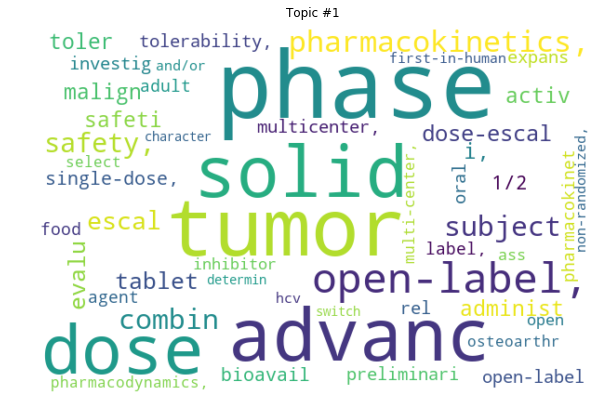

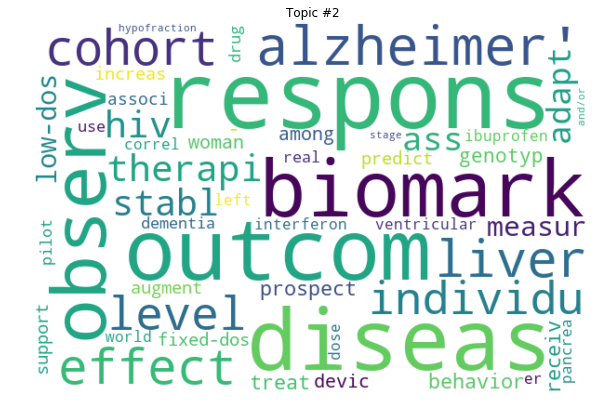

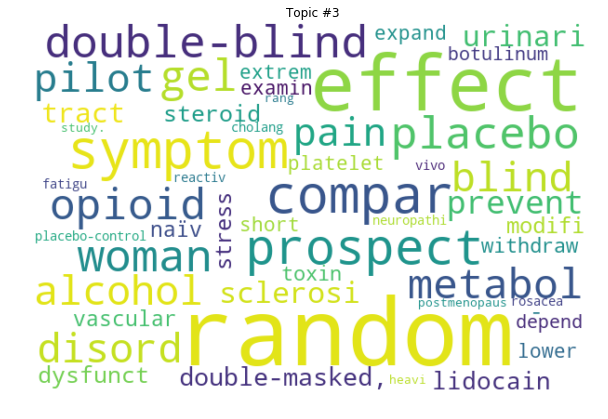

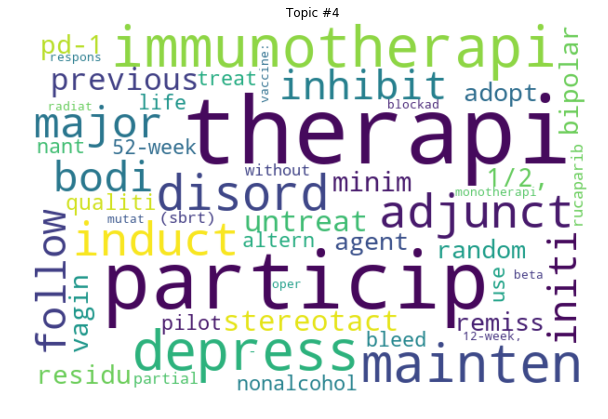

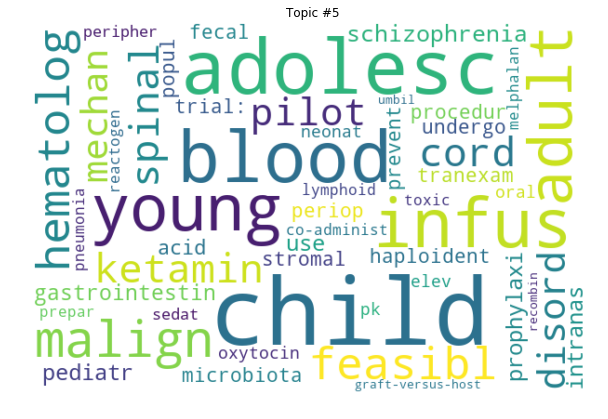

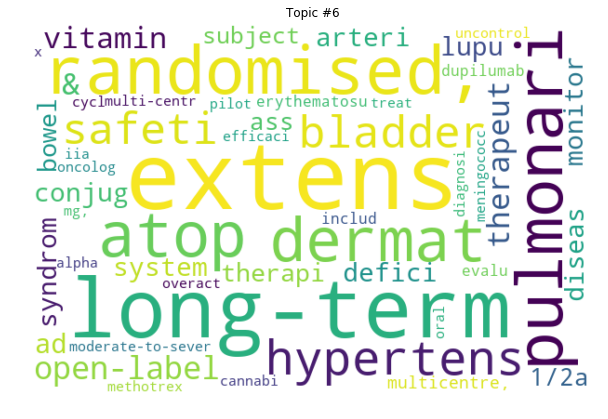

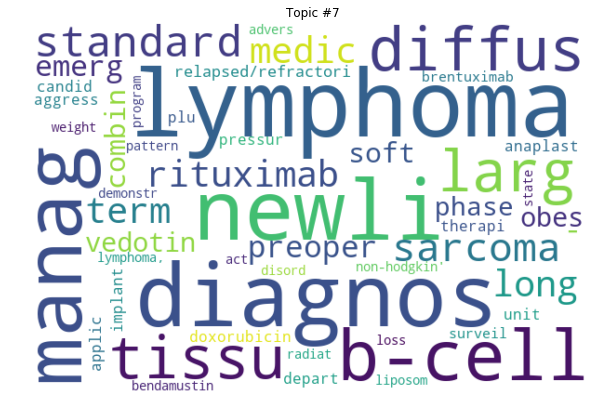

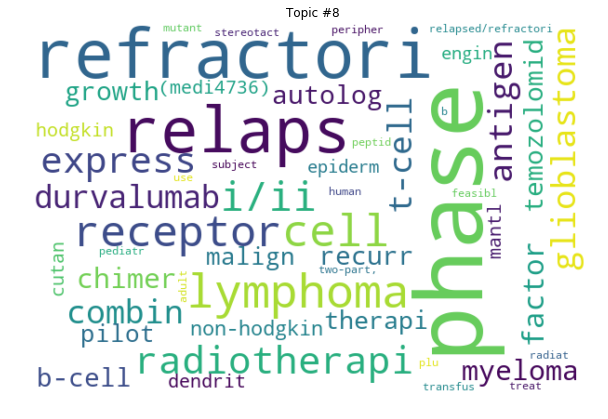

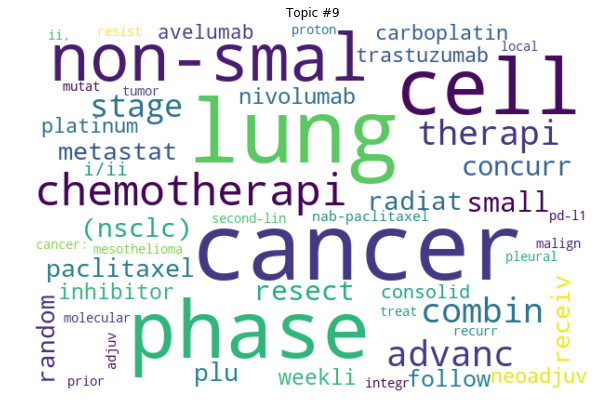

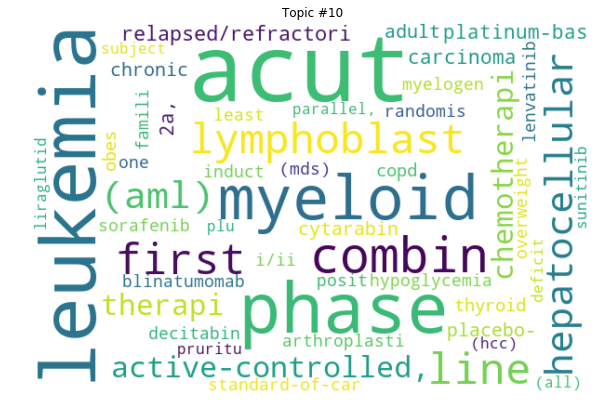

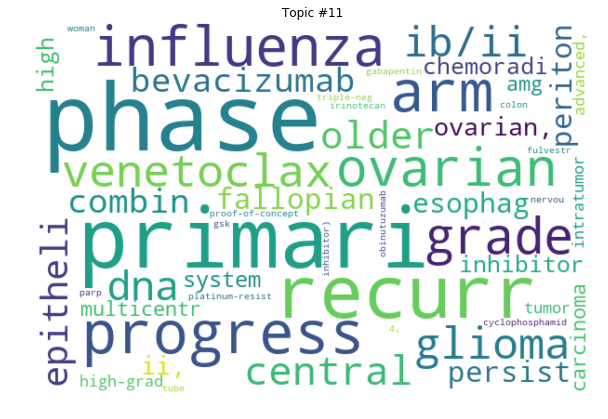

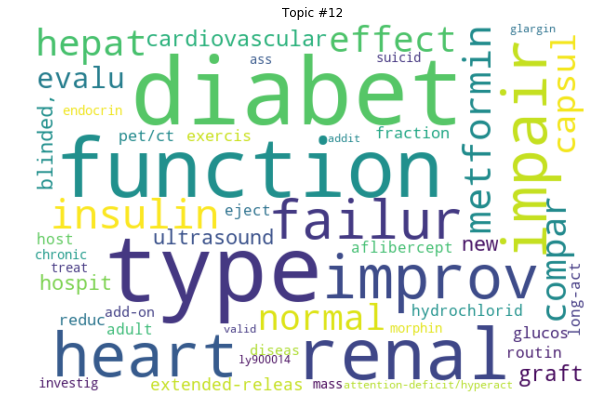

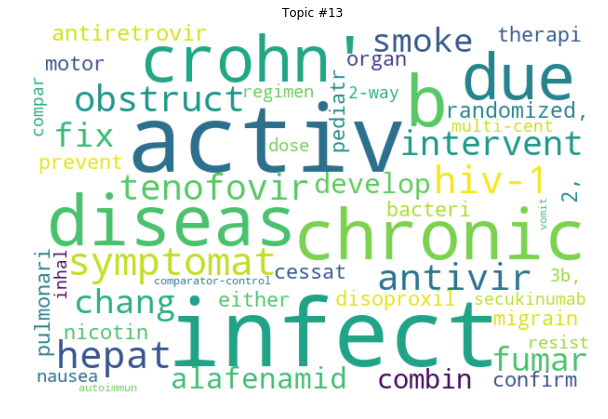

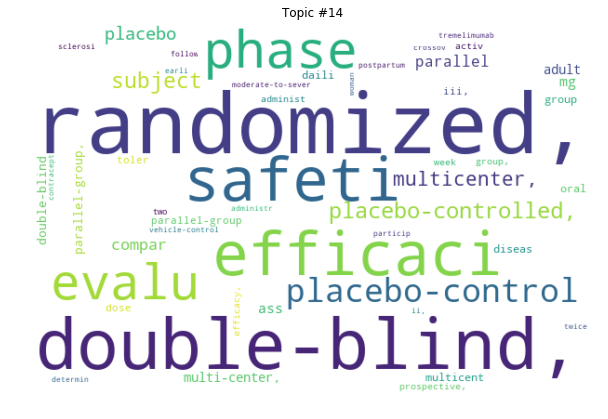

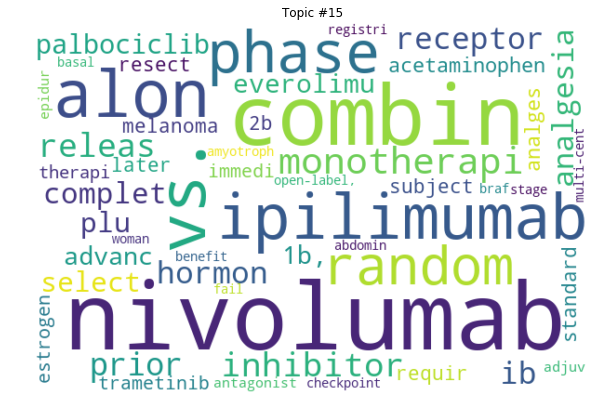

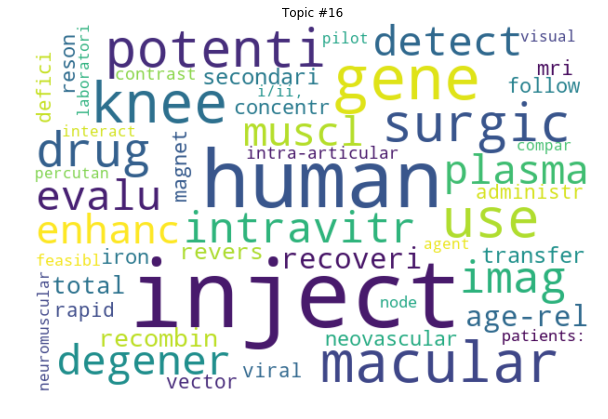

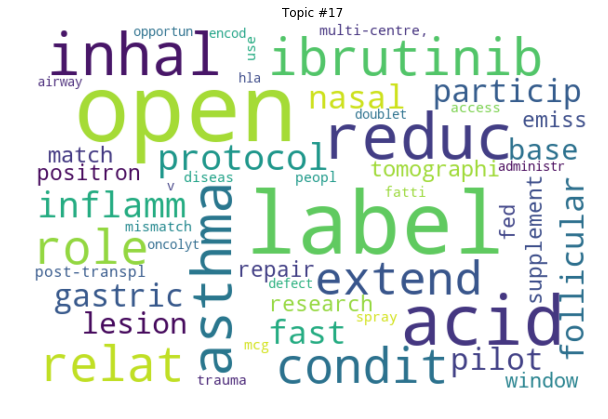

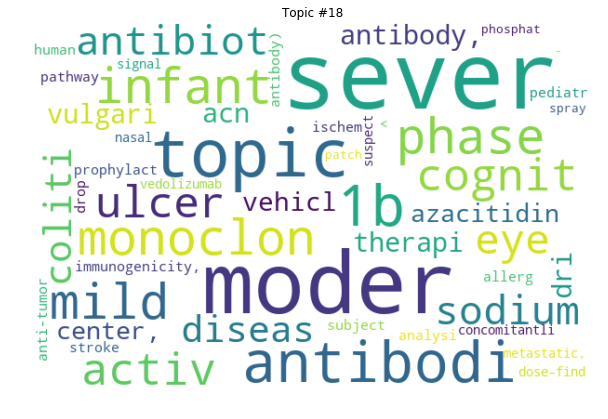

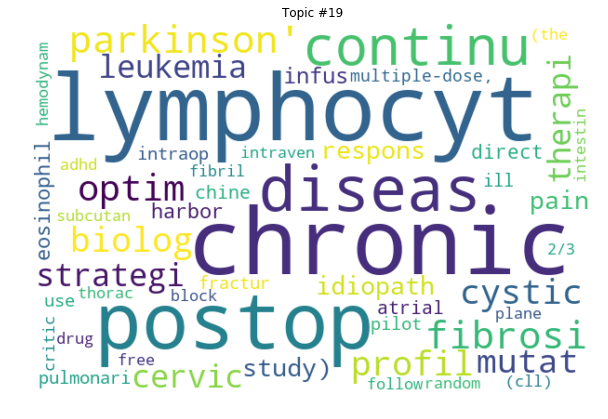

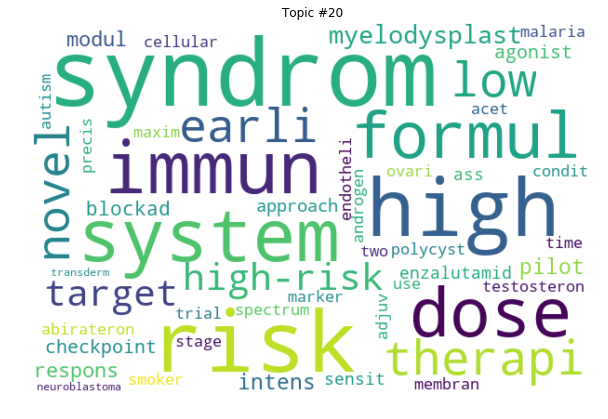

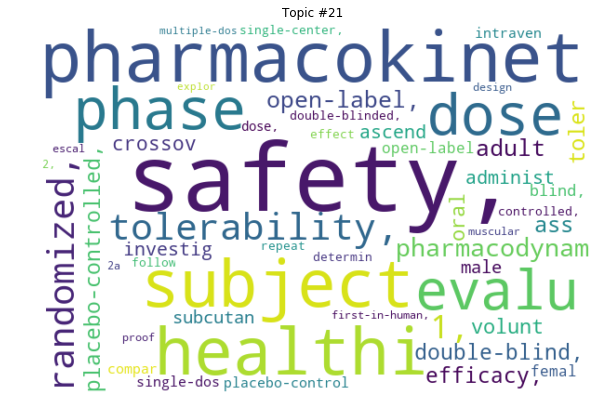

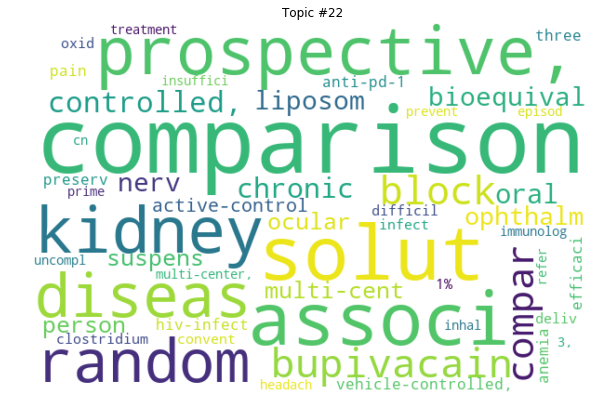

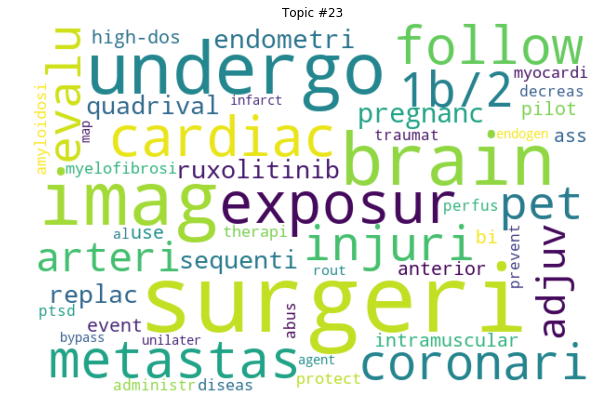

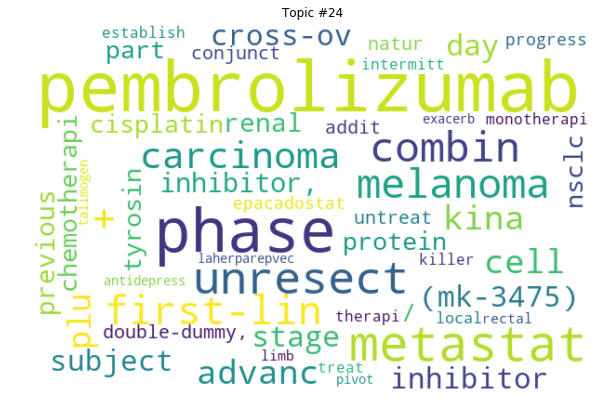

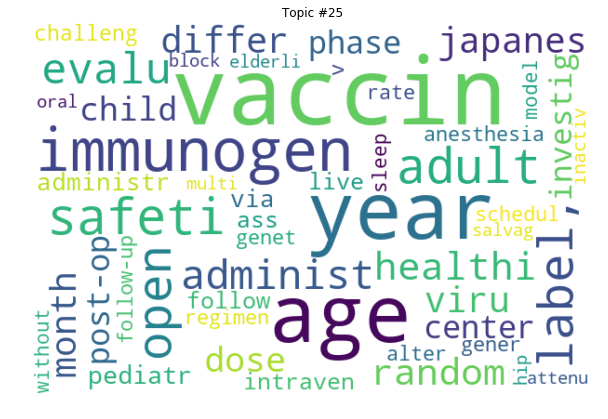

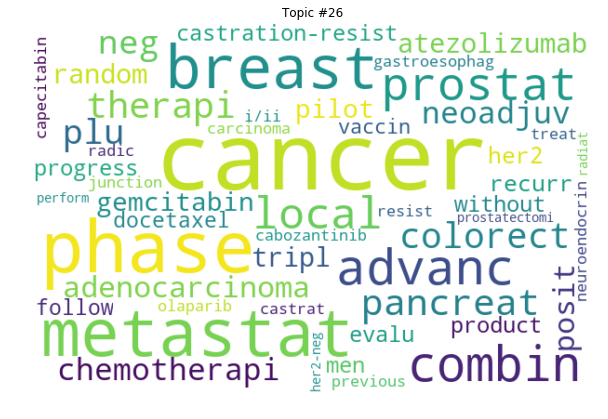

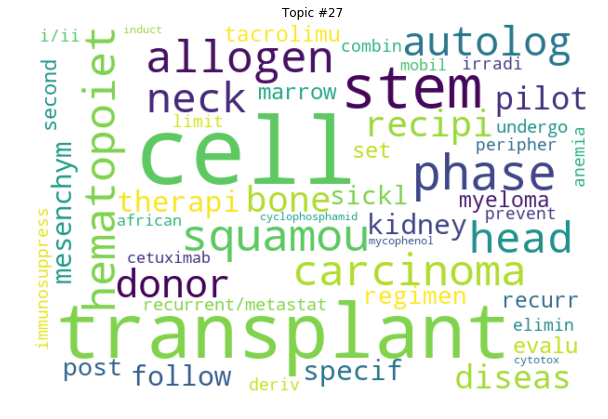

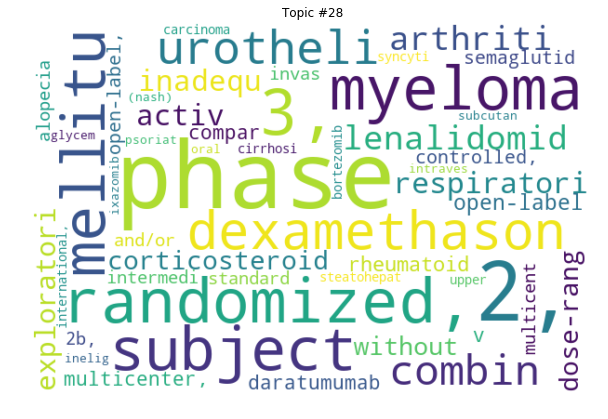

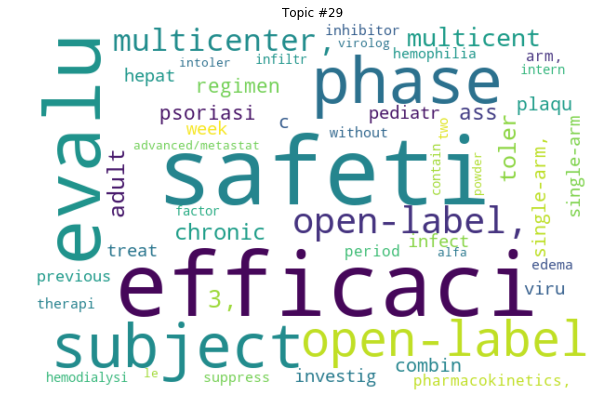

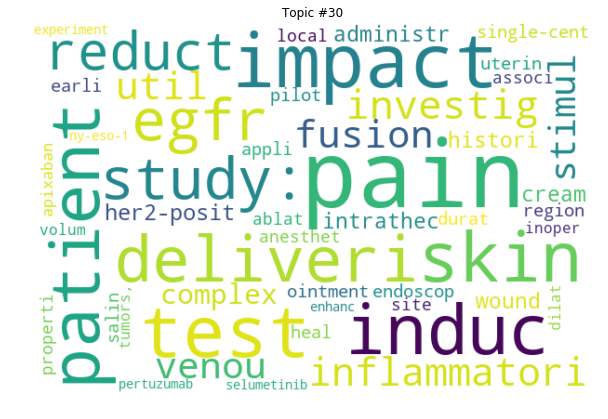

In [27]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white', max_font_size=100, width=600, height=400)

for t in range(ldamodel.num_topics):
    plt.figure(figsize=(10, 8))
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 50))), interpolation='bilinear')
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    plt.show()

In [28]:
doc_topics = []
top_topic_ids = []
dominant_topic_prob = []

for index, corp in enumerate(corpus):
    # Get the document-topic distribution for each document and sort it
    doc_topic_dist = ldamodel.get_document_topics(corp, minimum_probability=0)
    _srtd = sorted(doc_topic_dist, key=lambda x: x[1], reverse=True)
    top, score = _srtd[0]
    top_topic_ids.append(top+1)
    doc_topic = [tup[1] for tup in doc_topic_dist]
    dominant_topic_prob.append(max(doc_topic))
    doc_topics.append(doc_topic)


In [29]:
doc_topics_arr = np.asarray(doc_topics)

documents = final_data
NUM_DOCUMENTS = 20
top_documents_list = []
for topic_ in range(NUM_TOPICS):
    doc_ids = np.argsort(doc_topics_arr[:,topic_])[:-NUM_DOCUMENTS-1:-1]
    for doc_id in doc_ids:
        top_documents_list.append(((topic_ + 1), documents[doc_id]))
top_documents = pd.DataFrame(top_documents_list, columns=['topic_num', 'document'])
top_documents.to_csv('Goldman_top_documents.csv', index=False)


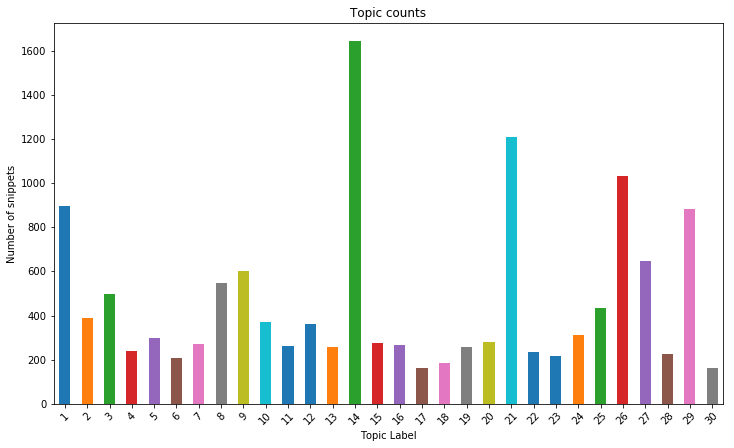

In [30]:
# plt.style.use('seaborn')
topics_count = pd.DataFrame(top_topic_ids, columns=['topic'])
topics_count = topics_count.reset_index().groupby('topic').count()
topics_count.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(12, 7))
topics_count.plot(kind='bar', x='topic', y='index', ax=ax, rot=45)
ax.set(title='Topic counts', xlabel='Topic Label', ylabel='Number of snippets')
ax.legend().set_visible(False)
plt.show()